In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
import sklearn.feature_selection as fs
import sklearn.linear_model as lm
from sklearn.metrics import r2_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
df = pd.read_csv('train.csv')
Y = df['SalePrice']
df = df.drop(['SalePrice'], axis=1)

In [ ]:
df.columns
df.head().loc[0]

## Data Exploration I

Upon doing a quick inspection of the data, I've devised with the following feature handling strategy: 
- variables with less than 20 unique values will be treated as categorical features, with the exception of
    - PoolArea
- the following features have more than 20 distinct values but will be treated as categorical
    - Neighborhood
    - YearBuilt
    - YearRemodAdd
    - GarageYrBlt
- the following features have less than 20 unique values, but will more appropriately be treated as continuous features
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - MoSold

In [3]:
not_converted = []
for col in df.columns:
    if (len(df[col].value_counts()) < 20):
        if col != 'PoolArea':
            df[col] = df[col].astype('category')
#             print(col + ' converted to Category')
    else:
        not_converted.append(col)
        
# Categorical variables that have more than 20 distinct values.
df['Neighborhood'] = df['Neighborhood'].astype('category')
df['YearBuilt'] = df['YearBuilt'].astype('category')
df['YearRemodAdd'] = df['YearRemodAdd'].astype('category')
df['GarageYrBlt'] = df['GarageYrBlt'].dropna().astype(int).astype('category')

# Variables with less than 20 distinct values, that are not categorical. They contain counts, and 
# will be treated as continuous/numeric.
to_convert = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
              'Fireplaces', 'GarageCars']

for col in to_convert:
    # convert cols back to int. 
    df[col] = df[col].astype(int)

Observations: 
   - The variables that are approximately normally distributed or have a skew, tend to be related to square footage.
   - There are a handful of discrete numerical variables representing counts
   - There are about 9 variables that look like they have a very low variability in information aka have a high percentage of one value.    

## Data Cleaning


### High percentage of NAs

Identifying variables with more than some percentage of NAs

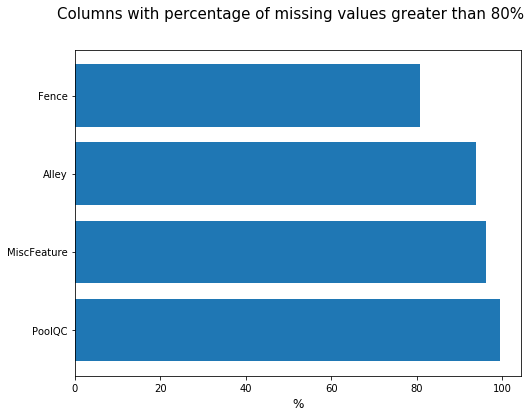

In [5]:
thresh = .8
nulls = df.isna().sum()

fig = plt.figure(figsize=(8, 6))
plt.barh(nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False).index, 
         (nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False)/df.shape[0]*100).values)
fig.suptitle('Columns with percentage of missing values greater than 80%', fontsize=15)
plt.xlabel('%', fontsize=12)
plt.show();

This plot suggests we should drop Alley, PoolQC, Fence, MiscFeature because they are over 80% null.
Upon looking at the data dict however, you'll see that the NAs represent the case where a house does not have a given feature, and are not actually `nulls`. 
Let this be a reminder to understand what the data represents.

### Fill missing values

In [6]:
# Separate out columns by data type to fill in missing values
integer_columns = df.select_dtypes(include=[np.int64, np.float64])
categorical_columns = df[df.select_dtypes(include=['category']).columns.union(['Id'])]

In [7]:
# Interpolate two fields using linear interpolation
integer_columns = integer_columns.interpolate()

In [9]:
# Handling the two fields where the NaNs do not correspond to a valid value.
# Fields 'Electrical' and "MasVnrType" have 8 and 1 missing values respectively. Since these are two fields
# where the NaN does not correspond to a value, and since there are so few records, we're dropping those.
categorical_columns = categorical_columns[~categorical_columns['Electrical'].isna()]
categorical_columns = categorical_columns[~categorical_columns['MasVnrType'].isna()]

# adding 'None' category to categorical fields, and then replacing NaN with 'None' for processing
def add_category(df, col):
    df[col].cat.add_categories('None', inplace=True)

null_categorical = categorical_columns.isna().sum().sort_values(ascending=False).reset_index()
null_categorical = null_categorical[null_categorical['index'] != 'Id']
for index, row in null_categorical.iterrows():
    if row[0] > 0:
        add_category(categorical_columns, row['index'])
        categorical_columns[row['index']] = categorical_columns[row['index']].fillna(value='None')

In [10]:
processed_df = integer_columns.join(categorical_columns.set_index('Id'), on='Id')

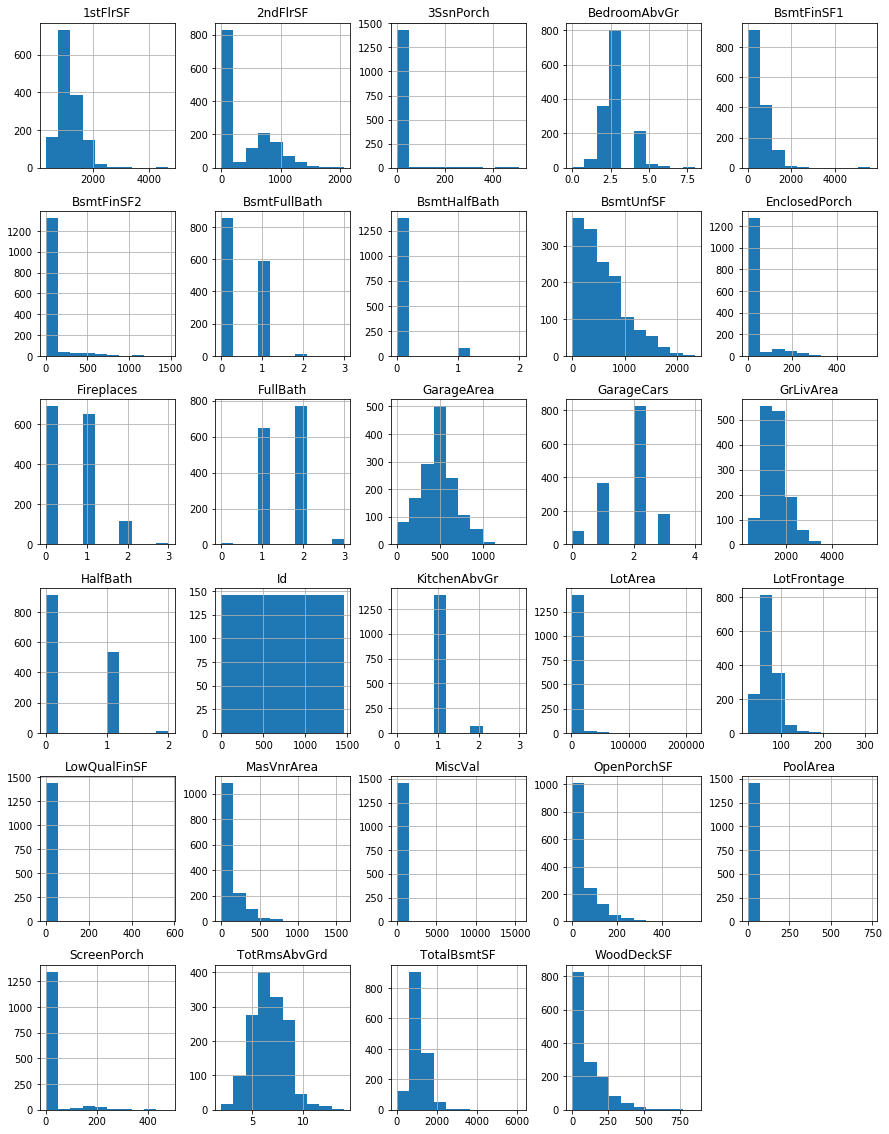

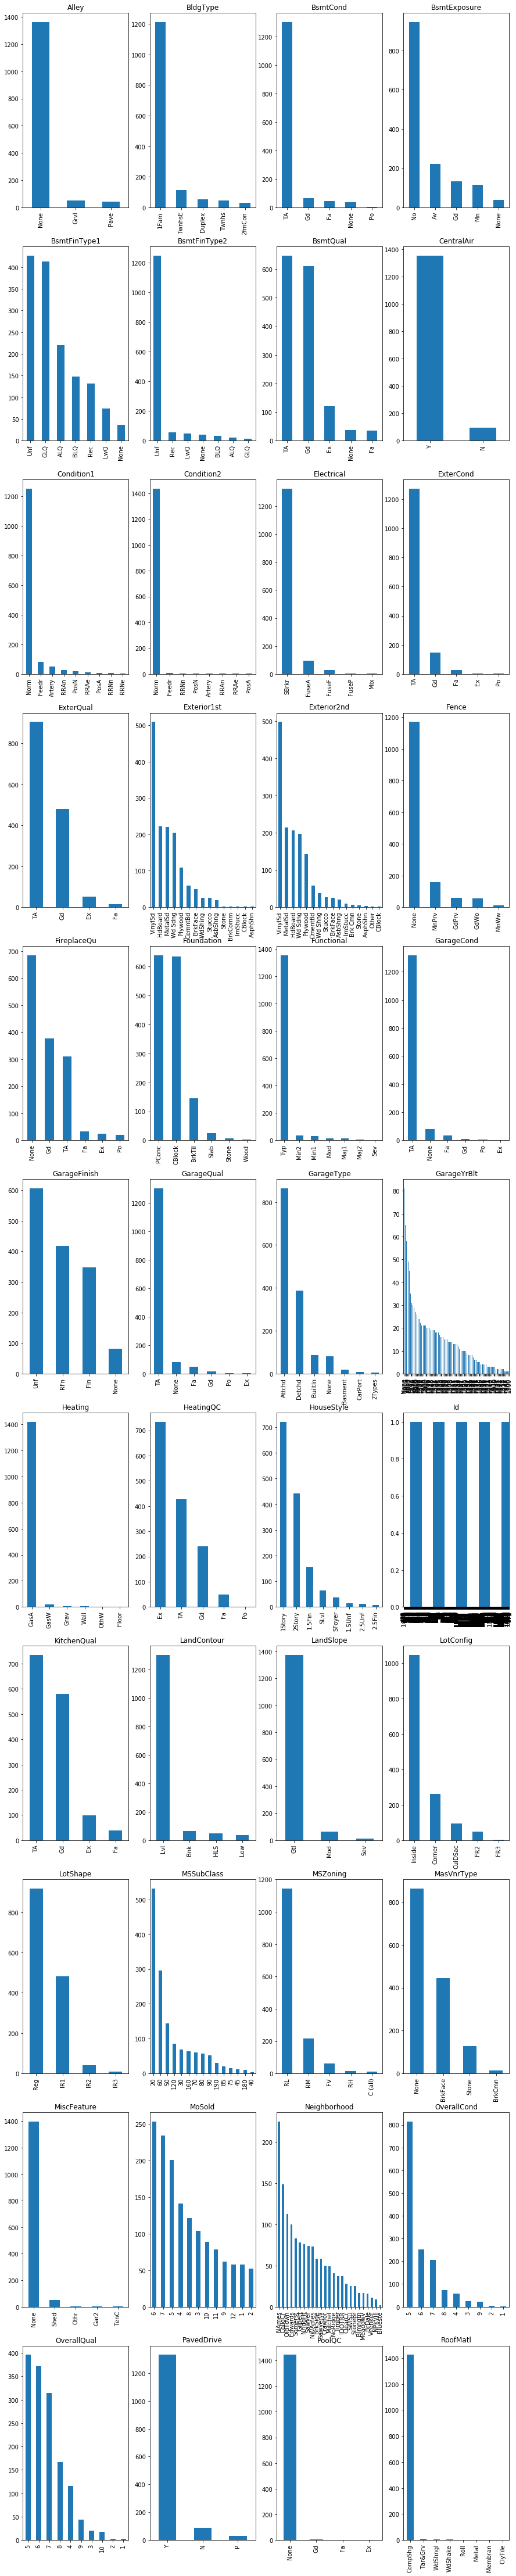

In [11]:
# plot the numerical variables
_ = integer_columns.hist(bins=10, figsize=(15, 20))

# plot the categorical variables

try:
    fig, ax = plt.subplots(11, 4)
    for i, cat in enumerate(categorical_columns.columns):
        _ = categorical_columns[cat].value_counts().plot('bar', ax=ax[i//4][i % 4], figsize=(15, 80)).set_title(cat);
    plt.show();
except IndexError:
    pass

### Predicting with linear models

In [12]:
X = pd.get_dummies(processed_df, drop_first=True)

In [13]:
# perform standardization of the data
# Fit the data to identify the mean and standard deviation
scalar = StandardScaler()
X_standardized = scalar.fit_transform(X)

# Lasso 

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
# fit linear models on X (original with dummy variables for categorical) and X2 (with feature selection for V[x] > 0.1)
reg = lm.LinearRegression().fit(X, Y)
reg
reg.score(X, Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

0.9463143699164405

Using Lasso in an attempt to achieve either this level of accuracy or better, while performing feature selection to make the model more interpretable. 

In [15]:

# Lasso Regression | L1 norm aka sum(abs(Beta)). Regularizes the loss with lambda*sum(abs(Beta))
reg4 = lm.Lasso(alpha=.5, fit_intercept=True, normalize=False).fit(X_standardized, Y)
reg4
reg4.score(X_standardized, Y)

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

0.9448960465334765

In [16]:
reg4.coef_

array([ 4.30287214e+02,  4.66209424e+02,  6.46626041e+03,  2.93519401e+03,
        1.37044111e+04,  2.89389506e+03,  5.84497891e+03,  4.31703528e+03,
        1.40262231e+04,  2.32739689e+04,  1.35523559e+02,  3.75697674e+03,
        1.56778919e+03,  1.27270689e+02,  2.81939914e+03,  1.44703352e+03,
       -3.25723249e+03, -4.43594720e+03,  2.47579039e+03,  3.52326515e+03,
        4.18368037e+03,  3.14132853e+03,  2.19001863e+03,  6.15367092e+02,
        6.54117706e+02,  1.43888960e+03,  2.80130445e+03, -5.21497738e+03,
       -9.33641370e+03, -3.46044614e+02, -1.59221786e+02, -5.96746526e+03,
       -1.00816420e+03, -1.87984023e+03, -1.84787955e+03,  6.25400655e+02,
       -2.70433903e+03,  2.16349227e+03,  2.97837700e+03,  3.30396739e+03,
       -4.80832024e+02, -2.00863116e+03, -8.86267203e+02,  1.15126337e+03,
        2.66385779e+03, -7.33869087e+01,  8.64730474e+01,  1.77596063e+03,
        1.07748794e+03, -8.78801386e+02, -3.23753653e+02, -1.34732315e+03,
       -1.34749039e+03, -

This was not very useful, as none of the betas were set to 0. I'll try a few values of alpha.

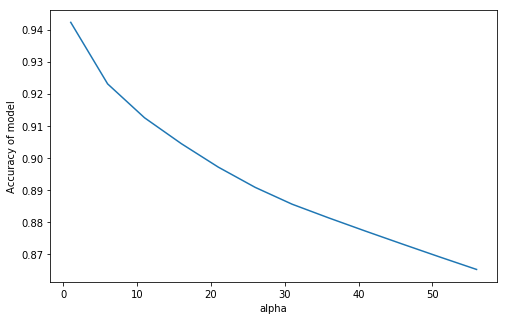

In [17]:
scores = []
for a in np.arange(1, 57, 5):
    regression = lm.Lasso(alpha=a, fit_intercept=True, normalize=True, max_iter=10000).fit(X_standardized, Y)
    scores.append(regression.score(X_standardized, Y))

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 57, 5), scores)
plt.xlabel('alpha')
plt.ylabel('Accuracy of model')
plt.show();

It appears that increasing the value of alpha only negatively impacts the prediction accuracy. Running the prediction with just an OLS approach performed better, so we can conclude Lasso is  not the best tool for this prediction. 

### WORK IN PROGRESS.

Let's build a model with variables that have a covariance below a certain threshold. When running a covariance matrix on the dataframe, we find that the covariances range from -0.04 to 100,000. Let's set the covariance threshold at 5000 and see what kind of results we get.

In [ ]:
test = df.cov()[abs(df.cov()) < 5000]

test['LotFrontage'].loc[~test['LotFrontage'].isnull()].index

# for col in test.columns:
    

In [ ]:
# Identifying variables with a covariance higher than 10,000
high_cov_cols = dict()
gt_thresh = df.cov()[abs(df.cov()) > 10000]
for col in df.cov():
    high_cov_cols[col] = list(df.cov().index[gt_thresh[col].notnull()])
# 

In [ ]:
high_cov_cols

In [ ]:
X.columns[~feat_sel.get_support()]

In [ ]:
# Experimenting with Feature Selection. Select features with a variance greater than 0.1.
feat_sel = fs.VarianceThreshold(threshold=(0.1))
var_sel = feat_sel.fit_transform(X)

# from X, drop the columns for the features whose variance did not meet the threshold, and 
# get dummy variables for remaining categorical features.
X2 = pd.get_dummies(X.drop(X.columns[~feat_sel.get_support()], axis=1)).dropna()

From the tests above, the $R^2$ to beat is 0.9454. I will continue first with testing feature selection methods. If I can achieve a sufficient improvement in $R^2$ with a subset of features, I will proceed to advanced regression techniques with that only those features. Otherwise, I will continue to performing advanced regressions with the full feature set.

In [ ]:
# Elasticnet: uses both the Ridge and Lasso penalties. Drawback of Lasso is that if there are a number of correlated 
# variables, it will only select one, and deselect for the rest. 

\begin{equation*}
{\hat {\beta }}\equiv {\underset {\beta }{\operatorname {argmin} }}(\|y-X\beta \|^{2}+\lambda _{2}\|\beta \|^2_2+\lambda _{1}\|\beta \|_{1})
\end{equation*}

scikit-learn's elasticnet implementation allows you to attribute weights (which sum to 1) to each of the penalties. Setting $l1_{ratio} = 1 $ will apply the Lasso, or $L1$ norm, penalty and setting $l1_{ratio} = 0$ will apply the Ridge, or $L2$ norm penalty. When $0 < l1_{ratio} < 1$ will apply some fraction of both penalties. The following is the objective function the implementation aims to minimize

\begin{equation*}
{\frac{1}{2*n_{samples}} * ||y - X\beta||^2_2
+ \alpha * l1_{ratio} * ||\beta||_1
+ 0.5 * \alpha * (1 - l1_{ratio}) * ||\beta||^2_2}
\end{equation*}